# To-do List
- generalize the code to work with a class structure (c.f. dedispersion)
    - match the colours of the plots to the standard colours
        - e.g. pink and red for E, cyan and blue for W
        - may need to change how the horn if statement works
- convert from FWHM to true beam width
    - mostly done but still unsure about 3D geometry
    - also need to confirm the 1e6 correction
- try removing the interferometry effect using an ifft

# (0) Set-up

In [2]:
import os
import numpy as np

from scipy import interpolate
import scipy
from scipy import sparse
from scipy.sparse.linalg import spsolve

import datetime

from astropy import coordinates as coord
from astropy import units as u
from astropy import constants as const
from astropy import time as astrotime
from astropy.coordinates import Angle

from matplotlib import pyplot as plt
from math import pi

In [3]:
pathtemplate = "C:/Users/jetso/Creative Cloud Files/Desktop/Uni/L-BASS"

filelist = []
for (dirpath, dirnames, filenames) in os.walk(pathtemplate):
    filelist.extend(filenames)
    break
print (filelist)

['accom1.PNG', 'accom2.PNG', 'L_BASS_first_paper_version_2(5).pdf', 'solar_transit.ipynb', 'solar_transit_21_03_22.csv', 'solar_transit_full_bandpass.ipynb', 'solar_transit_total_power.ipynb', 'travel.PNG', 'work_experience_proof.PNG']


# (1) Import Data
- Will first try with the 2022 data to compare to excel results
  - only using 18 Mar data but should **generalise the method into functions to work for any data**
- Then repeat with 2024 observation

## (1.1) Total and HI Powers

I use a class system here to make it easier to quickly view data.
I have a new form of data though and need to make it work again:
- I have folders for each date
- in each folder are 5 npy arrays
  - 4 spectrometer outputs
  - 1 for the datetime objects

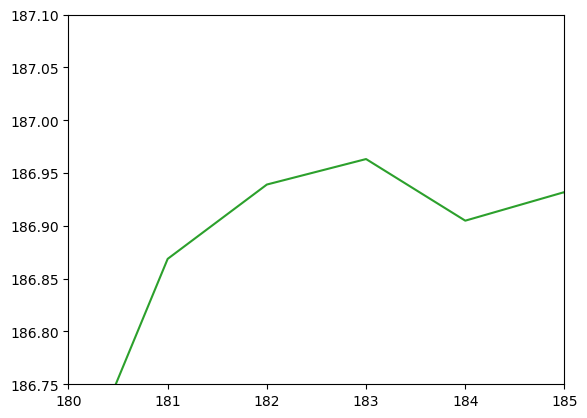

In [49]:
# creates a class object for each transit
# object will store the date and solar declination for each transit
# using get_data(), an array for the transit can be obtained
class Transit_total:
    def __init__(self, date, dec_L, dec_mid, dec_R, horn, noon):
        self.date = date
        self.dec_mid = dec_mid
        self.dec_L = dec_L
        self.dec_R = dec_R
        self.horn = horn
        self.noon = noon
        if horn == 'E':
            self.power_index = [0,1]
            self.baseline_index = [2,3]
        elif horn == 'W':
            self.power_index = [2,3]
            self.baseline_index = [0,1]
        else:
            self.power_index = [0,1,2,3] 
    def get_data(self):
        folder = os.path.join(pathtemplate,f"Data/{transit_total.date}")
        #print(os.listdir(folder))
        datetimes = np.load(os.path.join(folder, 'datetimes.npy'), allow_pickle=True)
        R0W = np.load(os.path.join(folder, 'R0W_powers.npy'), allow_pickle=True)
        L0E = np.load(os.path.join(folder, 'L0E_powers.npy'), allow_pickle=True)
        LpiW = np.load(os.path.join(folder, 'LpiW_powers.npy'), allow_pickle=True)
        RpiE = np.load(os.path.join(folder, 'RpiE_powers.npy'), allow_pickle=True)
        combined = np.vstack((L0E, RpiE, R0W, LpiW))
        return datetimes, combined

# this is a list of the transits
# ('date', left dec, noon dec, right dec, 'horn(s) used')
transit_total_list = [Transit_total('18th March 2022', 0, -0.84, 0, 'W', datetime.datetime(2022, 3, 18, 12, 17, 24)),
                      Transit_total('21st March 2022', 0, 0.34, 0, 'W', datetime.datetime(2022, 3, 21, 12, 16, 31)),
                      Transit_total('8th April 2022', 0, 7.3, 0, 'E', datetime.datetime(2022, 4, 8, 12, 11, 12)),
                      Transit_total('13th July 2022', 0, 21.78, 0, 'W', datetime.datetime(2022, 7, 13, 12, 14, 57)),
                      Transit_total('14th July 2022', 0, 21.63, 0, 'W', datetime.datetime(2022, 7, 14, 12, 15, 4)),
                      Transit_total('15th July 2022', 0, 21.48, 0, 'W', datetime.datetime(2022, 7, 15, 12, 15, 10)),
                      Transit_total('10th May 2024', 17.81, 17.82, 17.82, 'W', datetime.datetime(2024, 5, 10, 12, 5, 38)),
                      Transit_total('11th May 2024', 18.06, 18.07, 18.08, 'W', datetime.datetime(2024, 5, 11, 12, 5, 36)),
                      Transit_total('24th June 2024', 0, 0, 0, 'EW', datetime.datetime(2024, 6, 24, 12, 11, 41)),
                      Transit_total('25th June 2024', 0, 23.36, 0, 'EW', datetime.datetime(2024, 6, 25, 12, 11, 54)),
                      Transit_total('8th July 2024', 0, 22.38,0, 'E', datetime.datetime(2024, 5, 11, 12, 5, 36))]

transit_total = transit_total_list[6] # input the index of the desired transit
time, power = transit_total.get_data() # data is averaged into 1 min bins so a diff of 10 points is 10 mins

for i in range(0,len(power)):
    time_mins = np.array([(i - time[0]).total_seconds() / 60 for i in time])
    plt.grid()
    plt.plot(time_mins, power[i])
    plt.xlim(180,185)
    plt.ylim(186.75,187.1)

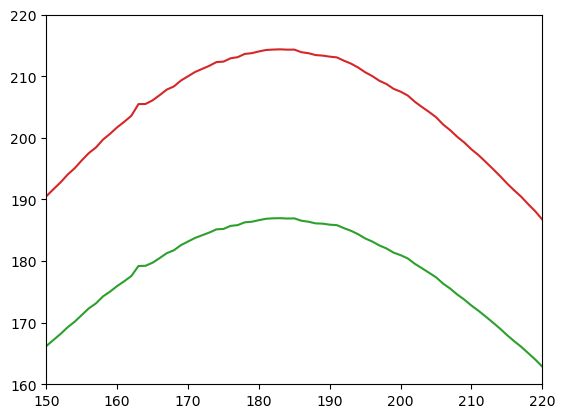
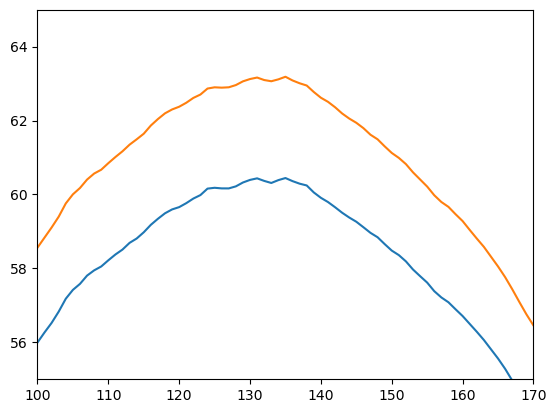

# (2) Finding FWHM

From ppt:
- differences in obs day accounted for by shifting and scaling amp
  - is this correct?
  - what if this has ignored a more fundamental issue?

- suggested solar flux variations not significant over transit
  - if they are how do we account for it?

- assumed the correction due to the Sun's transit not being flat is insignificant
  - if this is treated formally it may solve the discrepancy
  - has the movement of the Earth during the transit been accounted for?
    - obviously the rotation of Earth is the transit
    - but does its orbital motion need to be included too?
    - would this even been worthwhile doing? (too small an effect??)


In [5]:
def w_a(values, uncer):
    x = np.average(values, weights=1/uncer**2)
    dx = 1/np.sqrt(np.sum(1/uncer**2))
    return x,dx

In [6]:
def harry_plotter_gauss(t, p, parameters):
    plt.plot(t, p)
    plt.plot(t, gaussian(t, *parameters))

    plt.xlabel('time [mins]')
    plt.ylabel('power')
    plt.grid()
    #plt.show()
    return

In [7]:
def harry_plotter_baseline(t, p, parameters):
    plt.plot(t, p)
    plt.plot(t, gaussian_with_baseline(t, *parameters))

    plt.xlabel('time [mins]')
    plt.ylabel('power')
    plt.grid()
    #plt.show()
    return

## (2.2) Gaussian Fitting

In [8]:
def gaussian(x, a, b, c, d):
    return a*np.exp(-((x-b)**2)/(2*(c/(2*np.sqrt(2*np.log(2))))**2))+d

def gaussian_fitting(x, y):
    p0 = np.array([np.max(y), np.argmax(y), 98, 10])
    popt, pcov = scipy.optimize.curve_fit(gaussian, x, y, absolute_sigma=0, p0=p0)
    #absolute_sigma=0 to ensure uncertainties reflect the fitting
    return popt, pcov

In [9]:
def line_fitting(x_data, y_data, y_uncertainties):

    weights = 1. / y_uncertainties**2
    repeated_term = (np.sum(weights) * np.sum(x_data**2 * weights) - np.sum(x_data * weights)**2)

    slope = ((np.sum(weights) * np.sum(x_data * y_data * weights) - np.sum(x_data * weights) * np.sum(y_data * weights)) / repeated_term)
    slope_uncertainty = np.sqrt(np.sum(weights) / repeated_term)

    offset = ((np.sum(y_data * weights) * np.sum(x_data**2 * weights) - np.sum(x_data * weights) * np.sum(x_data * y_data * weights)) / repeated_term)
    offset_uncertainty = np.sqrt(np.sum(x_data**2 * weights) / repeated_term)

    return (np.array([slope, offset]), np.array([slope_uncertainty, offset_uncertainty]))

In [10]:
def baseline_correction(t, p, para):
    # take in power arrays and parameters
    # remove gaussian and only look at flat tails
    # fit straight line
    # subtract this from the data
    # return corrected power arrays
    peak = para[1]
    fwhm = para[2]
    edge_L = int(peak-1*fwhm)
    edge_R = int(peak+1*fwhm)

    comb = np.stack((t,p))
    #plt.plot(comb[0], comb[1])
    #plt.show()

    comb = np.delete(comb, range(edge_L,edge_R), axis=1)
    #print(comb.shape)
    #plt.plot(comb[0], comb[1], '.')
    #plt.show()
    

    return

In [11]:
def calc_beam_width(t, p, dec):
    time_mins = [(i - t[0]).total_seconds() / 60 for i in t]

    para, para_cov = gaussian_fitting(time_mins, p)
    para_err = np.sqrt(np.diag(para_cov))

    #theta = dec - (transit_total.dec_L*np.pi/180) NEED TO SORT THIS OUT !!!!!!!
    theta = 0
    
    fwhm_deg_temp = para[2]*np.cos(dec)*360/(23.9345*60*np.cos(theta))
    fwhm_deg_err_temp = para_err[2]*np.cos(dec)*360/(23.9345*60*np.cos(theta))

    peak = datetime.timedelta(minutes=para[1]) + t[0]
    peak_err = para_err[1]
    pointing_diff_mins = abs(peak-transit_total.noon).total_seconds()/60
    pointing_diff_temp = pointing_diff_mins*np.cos(sol_dec)*360/(23.9345*60)
    pointing_diff_err_temp = peak_err*np.cos(sol_dec)*360/(23.9345*60)

    #harry_plotter_gauss(time_mins, p, para)
    #plt.show()

    print(np.mean(abs(p-gaussian(time_mins, *para))))

    return fwhm_deg_temp, fwhm_deg_err_temp, pointing_diff_temp, pointing_diff_err_temp

0.07824190847181894
0.08041249621514858
0.03910515154239555
0.03988908261555435
0.08996494026441018
0.0811870443196804
0.05216605859899574
0.05244556415687083


0.19627679904230516
0.20661318540472104
0.1651972168448835
0.1806772512175097
0.3895985535315468
0.4324826571642803
0.4098416949013857
0.4671456013438503
mean fwhm: 23.13117636362695 +/- 0.006083627156855279 deg


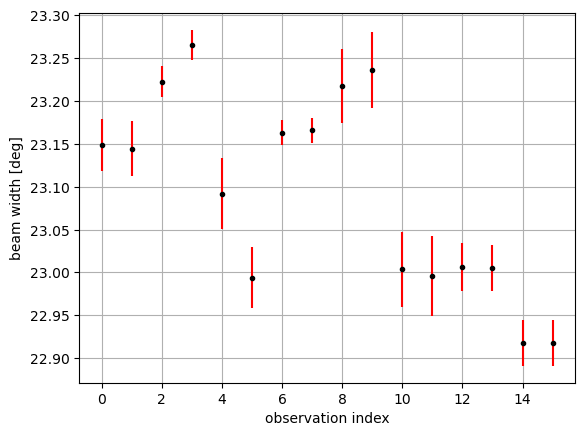

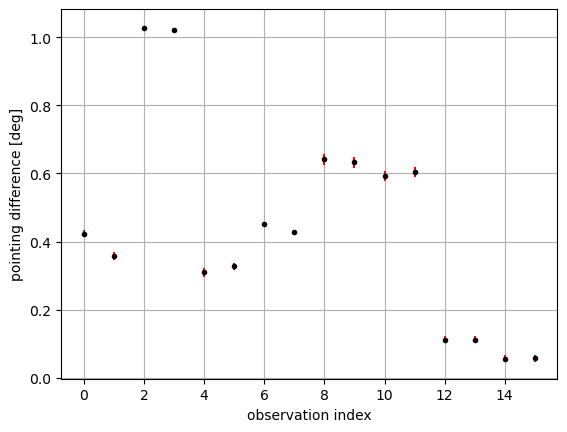

In [12]:
fwhm_deg = np.array([]) # empty array to store the FWHM values
fwhm_deg_err = np.array([])
pointing_diff = np.array([])
pointing_diff_err = np.array([])

for j in range(0,8):
    transit_total = transit_total_list[j]
    time, power = transit_total.get_data()
    sol_dec = transit_total.dec_mid*np.pi/180 

    for i in transit_total.power_index:
        fwhm, fwhm_err, pnt, pnt_err = calc_beam_width(time, power[i], sol_dec)
        fwhm_deg = np.append(fwhm_deg, fwhm)
        fwhm_deg_err = np.append(fwhm_deg_err, fwhm_err)
        pointing_diff = np.append(pointing_diff, pnt)
        pointing_diff_err = np.append(pointing_diff_err, pnt_err)
        # loops through each spectrometer output and calculates a FWHM adding it to an array

#print(fwhm_mins)
#print(fwhm_mins_err)
#print(pointing_diff)

mean_fwhm_deg, mean_fwhm_deg_err = w_a(fwhm_deg, fwhm_deg_err)

print(f'mean fwhm: {mean_fwhm_deg} +/- {mean_fwhm_deg_err} deg')

plt.errorbar(np.arange(0,len(fwhm_deg),1),fwhm_deg, fwhm_deg_err, fmt = 'k.', ecolor='r')
plt.xlabel('observation index')
plt.ylabel('beam width [deg]')
plt.grid()
plt.show()

plt.errorbar(np.arange(0,len(fwhm_deg),1), pointing_diff, pointing_diff_err, fmt='k.', ecolor='r')
plt.xlabel('observation index')
plt.ylabel('pointing difference [deg]')
plt.grid()
plt.show()



Attempting to fit a gaussian and straight line combined...

In [13]:
def gaussian_with_baseline(x, a, b, c, d, m):
    return a*np.exp(-((x-b)**2)/(2*(c/(2*np.sqrt(2*np.log(2))))**2)) + m*x + d

def gaussian_with_baseline_fitting(x, y):
    p0 = np.array([np.max(y), np.argmax(y), 98, 10, 1])
    popt, pcov = scipy.optimize.curve_fit(gaussian_with_baseline, x, y, absolute_sigma=0, p0=p0)
    #absolute_sigma=0 to ensure uncertainties reflect the fitting
    return popt, pcov

Could it be better to fit to a gaussian + sin as we would expect a very slow 

In [14]:
def calc_beam_width_with_baseline(t, p, dec):
    time_mins = np.array([(i - t[0]).total_seconds() / 60 for i in t])

    para, para_cov = gaussian_with_baseline_fitting(time_mins, p)
    para_err = np.sqrt(np.diag(para_cov))
    #print(para)

    #plt.plot(time_mins, p)
    #plt.plot(time_mins, gaussian(time_mins, *para[:-1]))
    #plt.plot(time_mins, para[4]*time_mins + para[3])
    #plt.plot(time_mins, gaussian_with_baseline(time_mins, *para))
    #plt.ylim(42,47)
    #plt.show()

    #print(np.mean(abs(p-gaussian_with_baseline(time_mins, *para))))

    #theta = dec - (transit_total.dec_L*np.pi/180) NEED TO SORT THIS OUT !!!!!!!
    theta = 0
    
    fwhm_deg_temp = para[2]*np.cos(dec)*360/(23.9345*60*np.cos(theta))
    fwhm_deg_err_temp = para_err[2]*np.cos(dec)*360/(23.9345*60*np.cos(theta))

    peak = datetime.timedelta(minutes=para[1]) + t[0]
    peak_err = para_err[1]
    pointing_diff_mins = (peak-transit_total.noon).total_seconds()/60
    pointing_diff_temp = pointing_diff_mins*np.cos(sol_dec)*360/(23.9345*60)
    pointing_diff_err_temp = peak_err*np.cos(sol_dec)*360/(23.9345*60)

    #harry_plotter_baseline(time_mins, p, para)
    #plt.show()

    print(para[-1])

    return fwhm_deg_temp, fwhm_deg_err_temp, pointing_diff_temp, pointing_diff_err_temp

18th March 2022


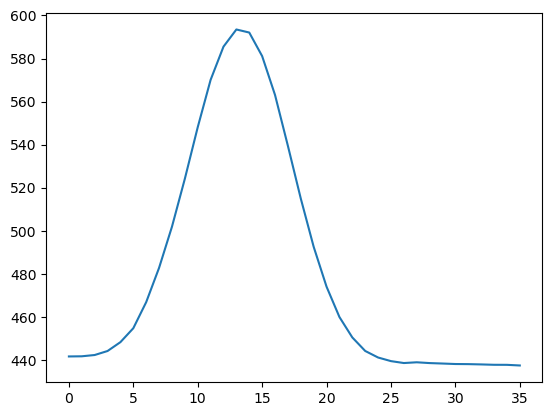

21st March 2022 didn't work
8th April 2022


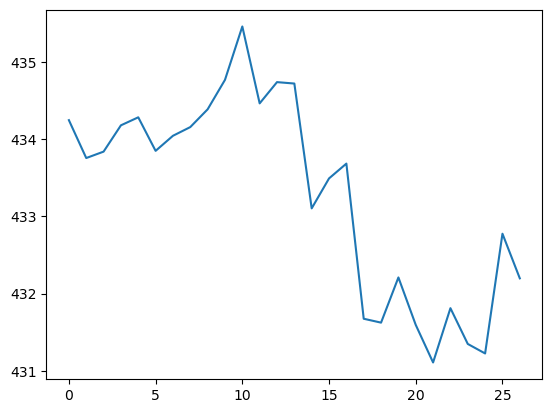

13th July 2022 didn't work
14th July 2022


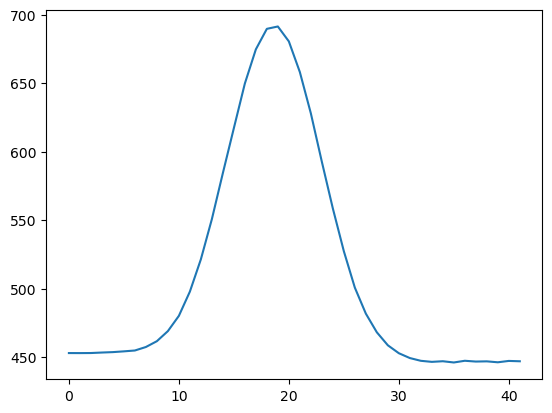

15th July 2022 didn't work
10th May 2024


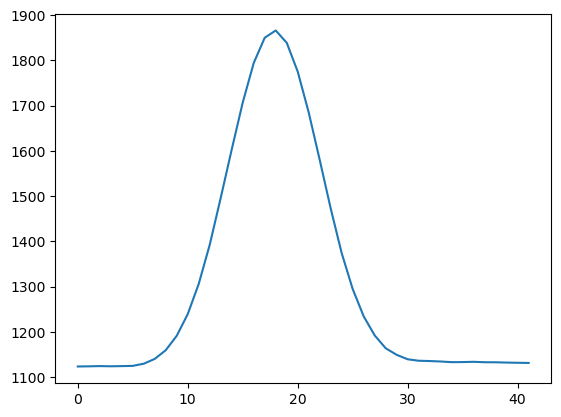

11th May 2024


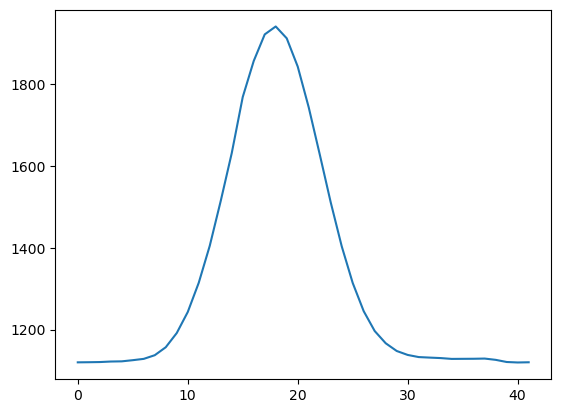

24th June 2024


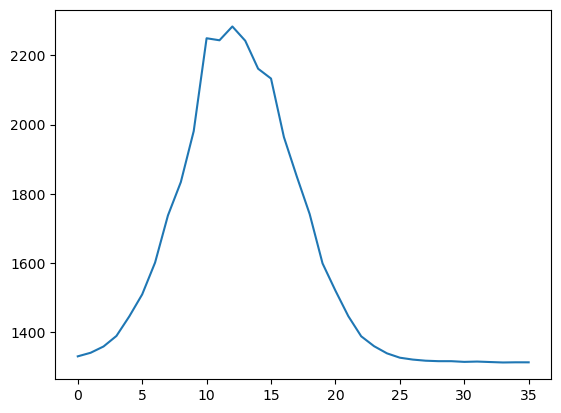

25th June 2024


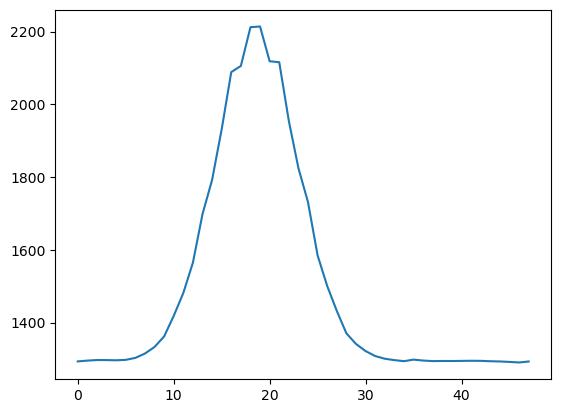

8th July 2024


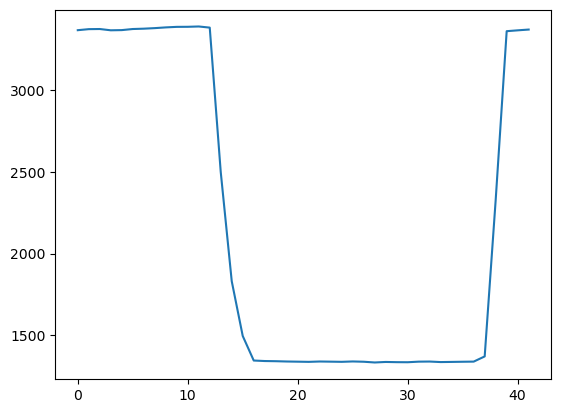

In [79]:
for i in range(len(transit_total_list)):
    transit_total = transit_total_list[i]

    time, power = transit_total.get_data()
    sol_dec = transit_total.dec_mid*np.pi/180

    power = power[2]

    if len(power)%10==0:
        print(transit_total.date)
        power_10 = np.sum(power.reshape(int(len(power)/10),10), axis=1)
        plt.plot(power_10)
        #plt.ylim(1000,1200)
        plt.show()
    else:
        print(f"{transit_total.date} didn't work")
        pass

[ 7.07987298e+02  4.49258010e+03  6.24597406e+03  8.14273610e+02
 -2.24040756e-03]


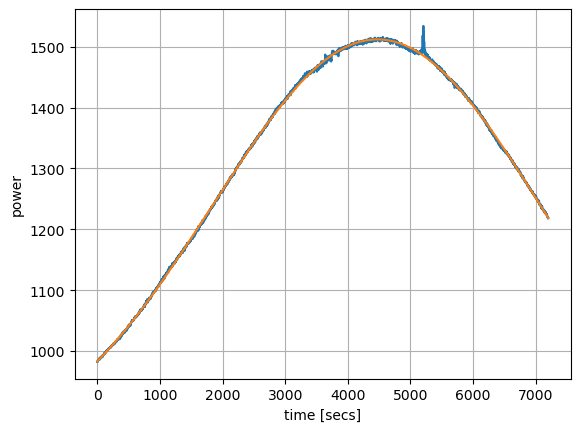

1.7169763579197757
24.353013112702968
[ 4.24757181e+04  7.43829620e+01  1.04097630e+02  4.88534364e+04
 -8.04265079e+00]


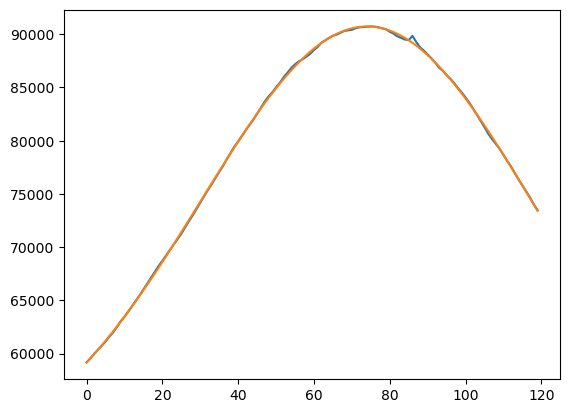

78.19710261096559
24.352559834642182


In [102]:
# USING SHINICHIROS DATA
sol_dec = 21.06 * np.pi/180

power = np.genfromtxt(os.path.join(pathtemplate,f"Data/L-BASS_beam_20240717.csv"))

time_secs = np.arange(0,7200,1)
para, para_cov = gaussian_with_baseline_fitting(time_secs, power)
para_err = np.sqrt(np.diag(para_cov))
print(para)
harry_plotter_baseline(time_secs, power, para)
plt.xlabel('time [secs]')
plt.show()
print(np.mean(abs(power-gaussian_with_baseline(time_secs, *para))))
#theta = dec - (transit_total.dec_L*np.pi/180) NEED TO SORT THIS OUT !!!!!!!
theta = 0

fwhm_deg = (para[2]/60)*np.cos(sol_dec)*360/(23.9345*60*np.cos(theta))
fwhm_deg_err = para_err[2]*np.cos(sol_dec)*360/(23.9345*60*np.cos(theta))

print(fwhm_deg)

power_10 = np.sum(power.reshape(int(len(power)/60),60), axis=1)

time_secs = np.arange(0,120,1)
para, para_cov = gaussian_with_baseline_fitting(time_secs, power_10)
para_err = np.sqrt(np.diag(para_cov))
print(para)
plt.plot(time_secs, power_10)
#plt.plot(time_secs, gaussian(time_secs, *para[:-1]))
#plt.plot(time_secs, para[4]*time_secs + para[3])
plt.plot(time_secs, gaussian_with_baseline(time_secs, *para))
#plt.ylim(42,47)
plt.show()
print(np.mean(abs(power_10-gaussian_with_baseline(time_secs, *para))))
#theta = dec - (transit_total.dec_L*np.pi/180) NEED TO SORT THIS OUT !!!!!!!
theta = 0

fwhm_deg = (para[2])*np.cos(sol_dec)*360/(23.9345*60*np.cos(theta))
fwhm_deg_err = para_err[2]*np.cos(sol_dec)*360/(23.9345*60*np.cos(theta))

print(fwhm_deg)

-0.000794850520669938
-0.0008367266481742272
-0.0004875005660738715
-0.0004968237705152073
-0.0011743761878056007
-0.0008246841869444614
0.0008666319869611507
0.000984036444867687
-0.0018873414701082213
-0.0019971408493382544
-0.001814190526661929
-0.0020861832863583382
0.00345978330998348
0.0038328513503208066
0.002307381826570926
0.0024986513765725034
mean fwhm: 23.095102998807917 +/- 0.0053802263696411156 deg


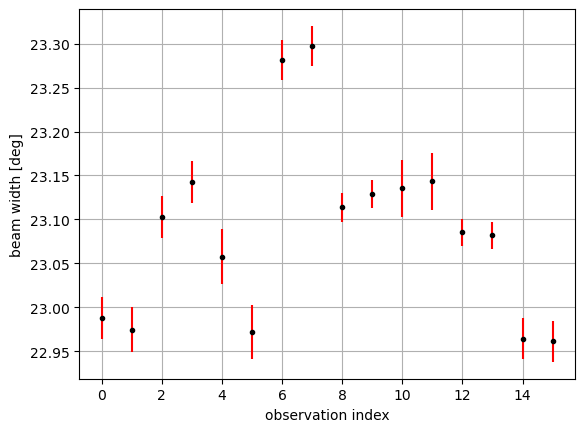

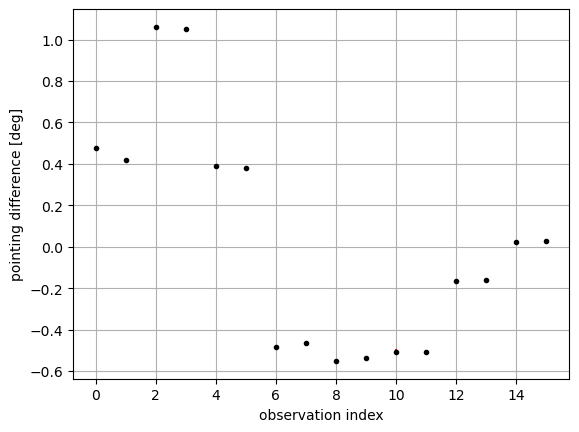

In [15]:
fwhm_deg = np.array([]) # empty array to store the FWHM values
fwhm_deg_err = np.array([])
pointing_diff = np.array([])
pointing_diff_err = np.array([])

for j in range(0,8):
    transit_total = transit_total_list[j]
    time, power = transit_total.get_data()
    sol_dec = transit_total.dec_mid*np.pi/180 

    for i in transit_total.power_index:
        fwhm, fwhm_err, pnt, pnt_err = calc_beam_width_with_baseline(time, power[i], sol_dec)
        fwhm_deg = np.append(fwhm_deg, fwhm)
        fwhm_deg_err = np.append(fwhm_deg_err, fwhm_err)
        pointing_diff = np.append(pointing_diff, pnt)
        pointing_diff_err = np.append(pointing_diff_err, pnt_err)

mean_fwhm_deg, mean_fwhm_deg_err = w_a(fwhm_deg, fwhm_deg_err)

print(f'mean fwhm: {mean_fwhm_deg} +/- {mean_fwhm_deg_err} deg')

plt.errorbar(np.arange(0,len(fwhm_deg),1),fwhm_deg, fwhm_deg_err, fmt = 'k.', ecolor='r')
plt.xlabel('observation index')
plt.ylabel('beam width [deg]')
plt.grid()
plt.show()

plt.errorbar(np.arange(0,len(fwhm_deg),1), pointing_diff, pointing_diff_err, fmt='k.', ecolor='r')
plt.xlabel('observation index')
plt.ylabel('pointing difference [deg]')
plt.grid()
plt.show()



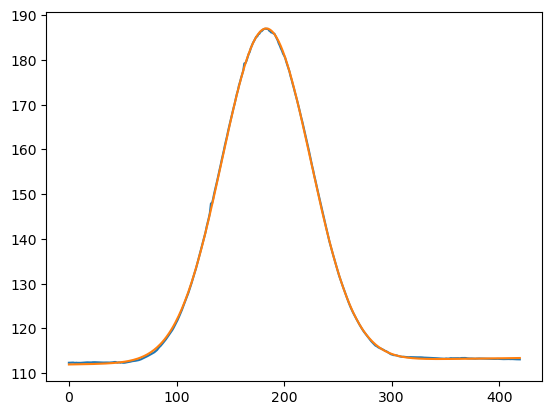

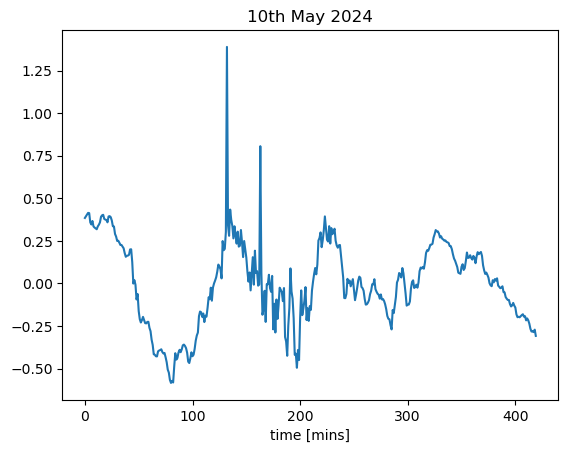

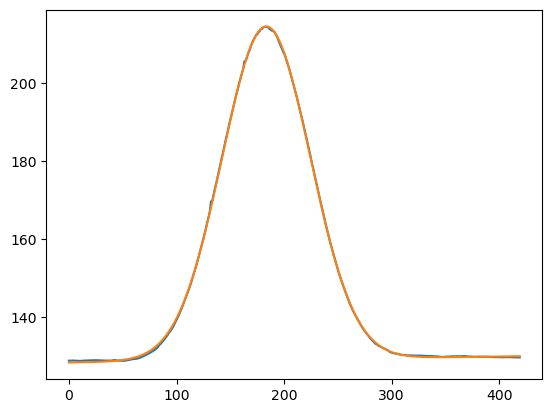

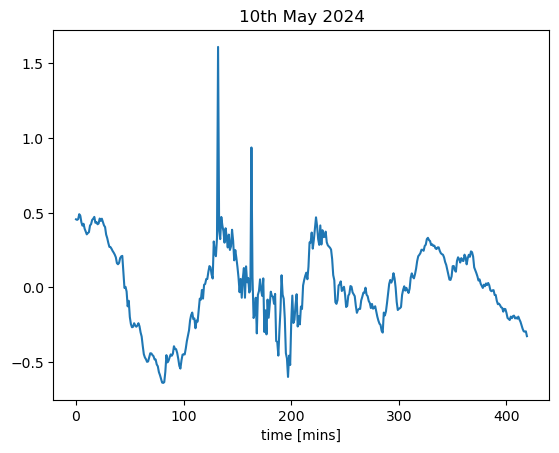

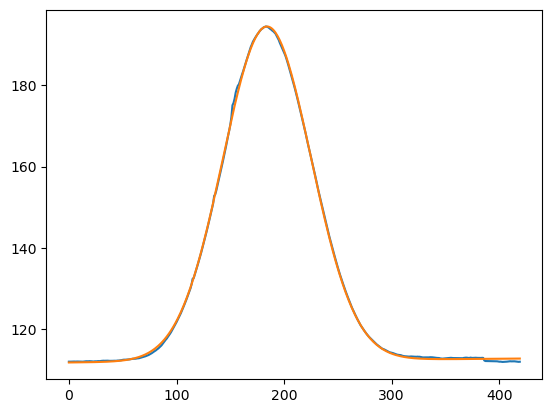

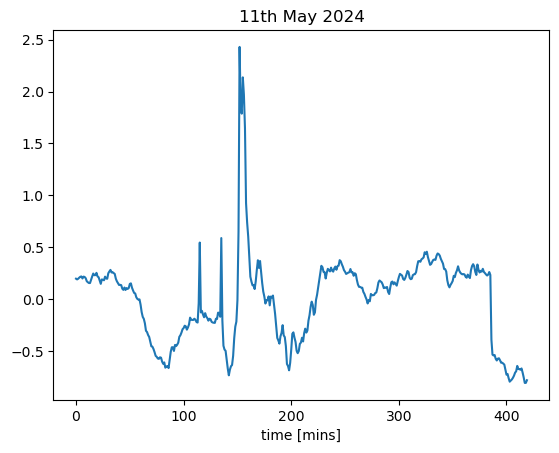

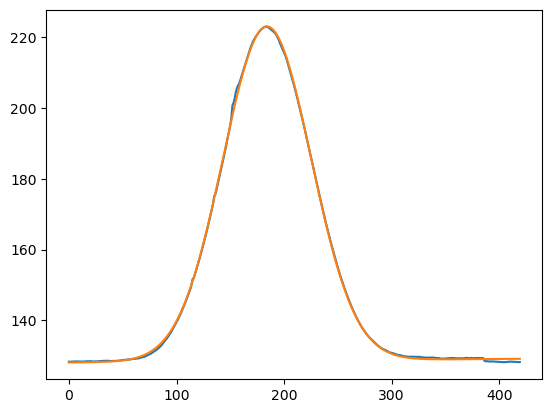

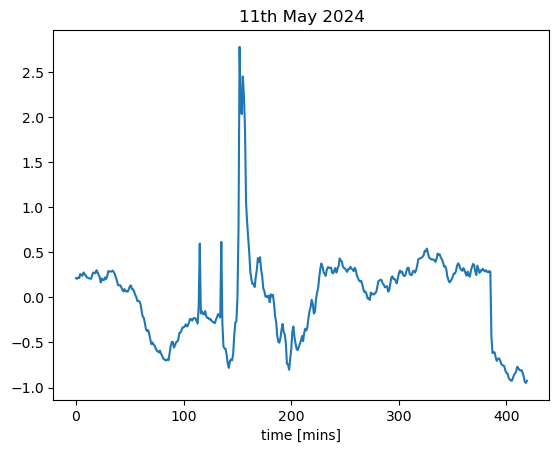

In [16]:
for j in range(6,8):
    transit_total = transit_total_list[j]
    time, power = transit_total.get_data()
    sol_dec = transit_total.dec_mid*np.pi/180

    for i in transit_total.power_index:
        time_mins = np.array([(j - time[0]).total_seconds() / 60 for j in time])

        para, para_cov = gaussian_with_baseline_fitting(time_mins, power[i])
        para_err = np.sqrt(np.diag(para_cov))
        
        #para2, para_cov2 = gaussian_fitting(time_mins, power[i])
        #para_err2 = np.sqrt(np.diag(para_cov2))
        
        plt.plot(time_mins, power[i])
        plt.plot(time_mins, gaussian_with_baseline(time_mins, *para))
        #plt.plot(time_mins, gaussian(time_mins, *para2))
        plt.show()
        

        plt.plot(time_mins, power[i]-gaussian_with_baseline(time_mins, *para))
        #plt.plot(time_mins, power[i]/gaussian(time_mins, *para2))
        #plt.xlim(100,260)
        plt.xlabel('time [mins]')
        #plt.title('25th June divided by gaussian with baseline')
        plt.title(transit_total.date)
        plt.show()

In [17]:
G1 = 1.0068
G2 = 1

A = 1
B = 7.4

effect = (2*(G1+G2)*(G1-G2)*A*B)/((G1+G2)**2*A**2+(G1-G2)**2*B**2)
print(effect)

0.050117980404776906


0.006776880530911843

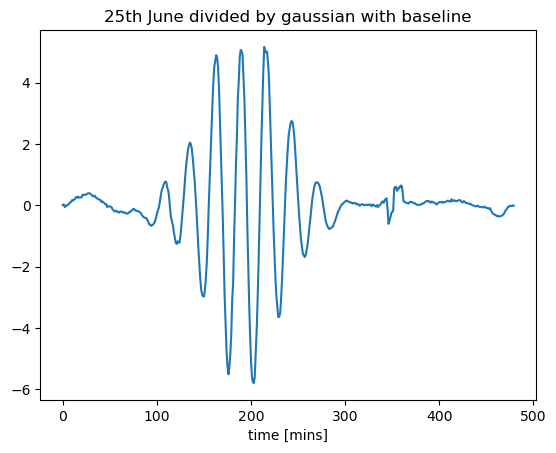
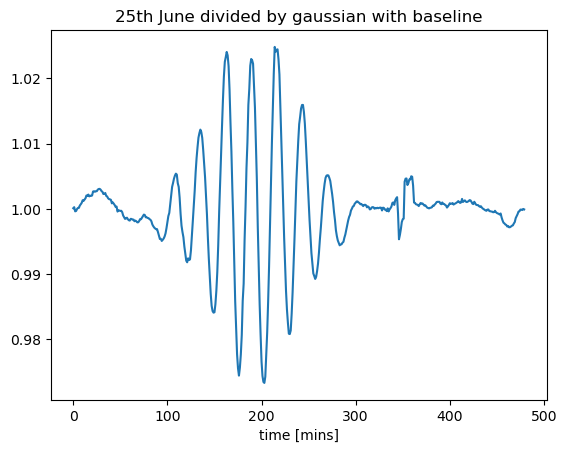